In [4]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from Models.PIVAE_pendulum import PIVAE
from physics import SimplePendulumSolver
from VAE_utils import q_net
from VAE_utils import vae_loss as KL_div

In [5]:
class PendulumDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.unique_intervals = df['interval'].unique()

    def __len__(self):
        return len(self.unique_intervals)

    def __getitem__(self, idx):
        batch = self.unique_intervals[idx]
        id = self.df['interval'] == batch
        theta = torch.tensor(self.df[id]['theta'].to_numpy(), dtype=torch.float32)
        t = torch.tensor(self.df[id]['t'].to_numpy(), dtype=torch.float32)  
        # Concatenate theta and t as input batch
        x_batch = torch.cat((theta.unsqueeze(1), t.unsqueeze(1)), axis=1)
        return x_batch # Also return omega for plotting

# Load the dataset
df_damped = pd.read_csv("../Data/damped_pendulum_data.csv")
df_damped['interval'] = df_damped['omega'].astype('category').cat.codes
df_damped['theta'] = df_damped['theta']

dataset = PendulumDataset(df_damped)
dataloader = DataLoader(dataset)
train_ratio = 0.7
test_ratio = 1-train_ratio

# Calculate split sizes
total_size = len(dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

seed = 42
generator = torch.Generator().manual_seed(seed)

# Split the dataset
train_subset, test_subset = random_split(
    dataset,
    [train_size, test_size],
    generator=generator
)
train_loader = DataLoader(train_subset, batch_size=1, shuffle=False)
val_loader = DataLoader(test_subset, batch_size=1, shuffle=False)


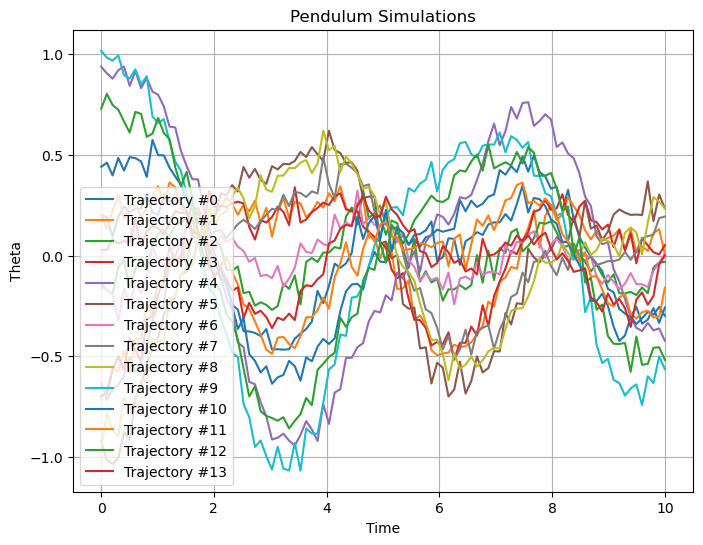

In [6]:
plt.figure(figsize=(8, 6))

for i, x_batch in enumerate(train_loader):
    x_batch = x_batch.squeeze(0)  # Now shape is (N, 2)

    # Extract theta and time
    theta_values = x_batch[:, 0].numpy()
    time_values = x_batch[:, 1].numpy()  # * 10  # Reverse normalization

    plt.plot(time_values, theta_values, label=f'Trajectory #{i}')

plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Pendulum Simulations")
plt.legend()
plt.grid()
plt.show()


In [7]:
torch.manual_seed(0)
model = PIVAE(hidden_layers=[10], 
              activation=nn.Tanh(),
              mu_prior=torch.tensor(0),
              var_prior=torch.tensor(2.0))
# Initialize model parameters and optimizer
pars = model.parameters()
opt = torch.optim.Adam(pars, lr=0.0001)

# Lists to store loss values
l_loss, KL, mse = [], [], []

beta_phy = 1
num_epochs = 200

l_loss, KL, mse = model.fit(dataloader, opt, beta_phy, num_epochs)


Progress: Epoch 40/200 | Loss=0.2002, KL=0.0946, MSE=0.1056
Progress: Epoch 80/200 | Loss=0.2090, KL=0.1055, MSE=0.1035
Progress: Epoch 120/200 | Loss=0.1886, KL=0.1008, MSE=0.0878
Progress: Epoch 160/200 | Loss=0.2321, KL=0.0989, MSE=0.1332
Progress: Epoch 200/200 | Loss=0.1866, KL=0.1025, MSE=0.0842


In [8]:
torch.save(model.state_dict(), 'pre_trained_models/PIVAE_pendulum.pth')